In [365]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
model = tf.keras.models.load_model('COMPUTER-VISION/pneumonia_model.keras')

In [ ]:
def get_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # 1. Define the input and reconstruct the layer path
    img_input = tf.keras.Input(shape=img_array.shape[1:])
    x = img_input
    target_conv_output = None
    
    for layer in model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            target_conv_output = x
            
    # 2. Build the Gradient Model
    grad_model = tf.keras.models.Model(img_input, [target_conv_output, x])

    # 3. Record gradients with GradientTape
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # Use index 0 for binary classification
        loss = predictions[:, 0]

    # 4. Compute importance and generate heatmap
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Apply weights and normalize
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

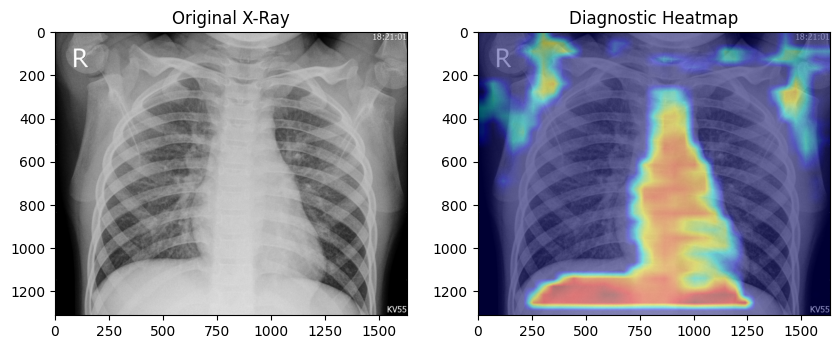

In [ ]:
# Configuration
IMG_PATH = "data/chest_xray/test/PNEUMONIA/person79_virus_148.jpeg"
LAST_CONV_LAYER = "conv2d_35" 

# 1. Preprocess image
img = tf.keras.preprocessing.image.load_img(IMG_PATH, target_size=(150, 150))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 2. Generate Heatmap
heatmap = get_gradcam_heatmap(img_array, model, LAST_CONV_LAYER)

# 3. Overlay Heatmap on Original Image
img_cv2 = cv2.imread(IMG_PATH)
heatmap_resized = cv2.resize(heatmap, (img_cv2.shape[1], img_cv2.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Combine original and heatmap (0.6 original, 0.4 heatmap)
output_img = cv2.addWeighted(img_cv2, 0.6, heatmap_colored, 0.4, 0)

# 4. Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original X-Ray")
plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Diagnostic Heatmap")
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.show()

In [369]:
print([layer.name for layer in model.layers])

['conv2d_33', 'max_pooling2d_33', 'conv2d_34', 'max_pooling2d_34', 'conv2d_35', 'max_pooling2d_35', 'flatten_11', 'dropout_11', 'dense_22', 'dense_23']



**NORMAL (Clear Lungs)**  
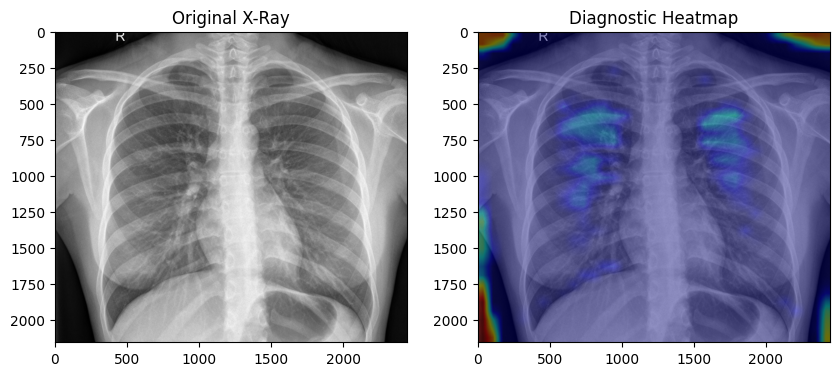


**Pneumonia**: Intense "hot" spots (red/yellow) over lung lobes. The model detected opacities or consolidations (fluid/pus) in the lungs.  
**Normal**: Weak, dispersed, or non-existent activation. The lungs are clear and well-aerated; the model found no suspicious density.  
**False Positive**: Hot spots on ribs, heart borders, or medical tubes.	The model is "distracted" by artifacts or high-contrast non-lung areas.